In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

try:
    from premier_league import (
        constants,
        preprocessing,
        preprocessing_helpers,
        training,
        evaluation,
        prediction,
        data_extraction,
        visualisations,
        s3_helpers,
        postgres,
        mlflow_functions,
        expectations_helpers,
        email_functions,
        data_drift_functions,
    )
except ModuleNotFoundError:
    import constants
    import preprocessing
    import preprocessing_helpers
    import training
    import evaluation
    import prediction
    import data_extraction
    import visualisations
    import s3_helpers
    import postgres
    import mlflow_functions
    import expectations_helpers
    import email_functions
    import data_drift_functions

2023-12-17 12:19:25,251 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

2023-12-17 12:19:28,257 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-17 12:19:28,732 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [3]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [4]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = expectations_helpers.AutoGreatExpectations(df)

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

Generating expectations
Done


In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    expectations_helpers.view_suite_summary(ge_data)

2023-12-17 12:19:29,019 - PremierLeagueLogger - INFO - Total Expectations: 18
2023-12-17 12:19:29,177 - PremierLeagueLogger - INFO - Counts:
2023-12-17 12:19:29,378 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-12-17 12:19:29,549 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-12-17 12:19:29,760 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-12-17 12:19:29,944 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-12-17 12:19:30,133 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-12-17 12:19:30,346 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-12-17 12:19:30,553 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-12-17 12:19:30,740 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-12-17 12:19:30,959 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-12-17 12:19:31,139 - Premie

In [7]:
# Save expectations to S3
expectations_helpers.save_expectations(
    ge_data,
    f'app_data/expectations/exp_prem_results_{constants.current_time}.json'
)

2023-12-17 12:19:31,389 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/exp_prem_results_20231217.json
2023-12-17 12:19:31,796 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/exp_prem_results_20231217.json


### Validate data

In [8]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-12-17 12:19:32,319 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-12-17 12:19:32,602 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231217.json
2023-12-17 12:19:32,860 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231217.json


In [9]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION
    )


2023-12-17 12:19:33,167 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-17 12:19:33,962 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [10]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-12-17 12:19:34,193 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-12-17 12:19:35,096 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-12-17 12:19:37,416 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [11]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-12-17 12:19:37,664 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-12-17 12:19:37,863 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231217.json
2023-12-17 12:19:38,798 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231217.json


In [12]:
if not validation_results['success']:
    email_functions.send_email(
        'data_validation',
        constants.S3_BUCKET, 
        expectations_helpers.latest_exp_file(),
        constants.VALIDATION_TOPIC, 
    )
    raise Exception('Stopping Pipeline. Validation has failed')

### Data Drift Detection

In [13]:
# Load historical data
historical = s3_helpers.grab_data_s3(
    constants.HISTORICAL_DATA_DRIFT
)

2023-12-17 12:19:39,121 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/historical_pl_data.csv
2023-12-17 12:19:40,113 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/historical_pl_data.csv


In [14]:
data_drift = data_drift_functions.DriftDetector(
    historical,
    full_data
)

In [15]:
drift_report = data_drift.check_data_drift(
    constants.DRIFT_REPORT_LOC
)

2023-12-17 12:19:41,315 - PremierLeagueLogger - INFO - Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231217.html
INFO:PremierLeagueLogger:Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231217.html
2023-12-17 12:19:50,210 - PremierLeagueLogger - INFO - Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231217.html
INFO:PremierLeagueLogger:Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231217.html


{'drift_share': 0.5, 'number_of_columns': 7, 'number_of_drifted_columns': 0, 'share_of_drifted_columns': 0.0, 'dataset_drift': False}


### Preprocessing

In [16]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

2023-12-17 12:19:50,840 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-17 12:19:51,847 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Successfully loaded data from premier-league-app/app_data/training_data_full.csv


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [17]:
transformers = preprocessing.fit_transformers(
    df
)

2023-12-17 12:19:52,239 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer
2023-12-17 12:19:52,628 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer


In [18]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

2023-12-17 12:20:16,125 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231217.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231217.pkl
2023-12-17 12:20:16,444 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231217.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231217.pkl


In [19]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

2023-12-17 12:20:16,660 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data
2023-12-17 12:20:16,877 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data


In [20]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [21]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-12-17 12:20:40,126 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [22]:
training_data.shape

(8640, 33)

In [23]:
testing_data.shape

(2160, 33)

In [24]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,2006-07,Watford,Man City,1,25.0,27.0,56.0,38.0,0.657143,1.171429,...,-0.885714,-0.314286,-0.514286,-0.142857,18,11,7,Saturday,April,21
1,2005-06,Charlton,Fulham,1,13.0,7.0,8.0,13.0,1.777778,0.555556,...,0.555556,-0.666667,1.222222,0.333333,2,10,-8,Monday,October,17


### Model Training

In [25]:
target_column = 'FTR'

In [26]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

2023-12-17 12:20:40,383 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-17 12:20:40,555 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-17 12:20:40,820 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:20:41,010 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:20:43,806 - PremierLeagueLogger - INFO - Loss: -0.5266203703703703
INFO:PremierLeagueLogger:Loss: -0.5266203703703703


 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 1/2 [00:03<00:03,  3.15s/trial, best loss: -0.5266203703703703]

2023-12-17 12:20:43,972 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:20:44,176 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:20:45,229 - PremierLeagueLogger - INFO - Loss: -0.5231481481481481
INFO:PremierLeagueLogger:Loss: -0.5231481481481481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/trial, best loss: -0.5266203703703703]


In [27]:
print(hyperparameters)

{'learning_rate': 0.09000000000000001, 'iterations': 400, 'max_depth': 10}


In [28]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-12-17 12:20:45,646 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
INFO:PremierLeagueLogger:Grabbing instance status of premier-league-logging
2023-12-17 12:20:46,500 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Starting RDS instance 'premier-league-logging'
2023-12-17 12:20:47,042 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-17 12:22:47,766 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-17 12:24:49,101 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-17 12:26:49,584 - PremierLeagueLogger - INFO - RDS instance status

In [29]:
# Open mlflow tracking
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [30]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

2023-12-17 12:28:52,269 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-17 12:29:22,581 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [31]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

2023-12-17 12:29:27,071 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/classifier_v2_20231217.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/classifier_v2_20231217.pkl
2023-12-17 12:29:57,929 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/classifier_v2_20231217.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/classifier_v2_20231217.pkl


### Prediction

In [32]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [33]:
predictions = prediction.predict(x_test, classifier)

2023-12-17 12:29:58,183 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


### Evaluation

In [34]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

2023-12-17 12:29:58,397 - PremierLeagueLogger - INFO - Evaluating result model
INFO:PremierLeagueLogger:Evaluating result model
2023-12-17 12:29:58,992 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


In [35]:
evaluation_metrics

{'mcc': 0.23024013287412934,
 'accuracy': 0.5277777777777778,
 'f1': 0.49109352522499927,
 'confusion_matrix': [[788, 81, 121], [319, 83, 132], [313, 54, 269]]}

### Part 2: Predict Score

In [36]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

2023-12-17 12:29:59,696 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [37]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

2023-12-17 12:30:00,065 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_cc.csv
INFO:PremierLeagueLogger:Savng data to premier-league-app/app_data/transformed_data_cc.csv


In [38]:
transformed_data.shape

(10800, 36)

In [39]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-12-17 12:30:04,911 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [40]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-12-17 12:30:05,191 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-17 12:30:05,474 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-17 12:30:05,714 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:30:05,904 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:30:06,879 - PremierLeagueLogger - INFO - Loss: 1.4383760438625026
INFO:PremierLeagueLogger:Loss: 1.4383760438625026


 50%|████████████████████████████████████████████████████████████████████                                                                    | 1/2 [00:01<00:01,  1.34s/trial, best loss: 1.4383760438625026]

2023-12-17 12:30:07,056 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:30:07,266 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:30:08,648 - PremierLeagueLogger - INFO - Loss: 1.438611413335622
INFO:PremierLeagueLogger:Loss: 1.438611413335622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/trial, best loss: 1.4383760438625026]


In [41]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-12-17 12:30:08,829 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-17 12:30:12,964 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [42]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

2023-12-17 12:30:15,967 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231217.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231217.pkl
2023-12-17 12:30:23,894 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231217.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231217.pkl


In [43]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-12-17 12:30:24,134 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-17 12:30:24,345 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-17 12:30:24,582 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:30:24,771 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:30:25,376 - PremierLeagueLogger - INFO - Loss: 1.0762960670592252
INFO:PremierLeagueLogger:Loss: 1.0762960670592252


 50%|████████████████████████████████████████████████████████████████████                                                                    | 1/2 [00:00<00:00,  1.04trial/s, best loss: 1.0762960670592252]

2023-12-17 12:30:25,541 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-17 12:30:25,845 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-17 12:30:26,424 - PremierLeagueLogger - INFO - Loss: 1.0836079114540096
INFO:PremierLeagueLogger:Loss: 1.0836079114540096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/trial, best loss: 1.0762960670592252]


In [44]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-12-17 12:30:26,812 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-17 12:30:28,820 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [45]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

2023-12-17 12:30:31,776 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231217.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231217.pkl
2023-12-17 12:30:34,373 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231217.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231217.pkl


### Predict Home Goals

In [46]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [47]:
predictions_1 = prediction.predict(x_test, regressor_1)

2023-12-17 12:30:34,621 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [48]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

2023-12-17 12:30:34,892 - PremierLeagueLogger - INFO - Evaluating home model
INFO:PremierLeagueLogger:Evaluating home model
2023-12-17 12:30:35,546 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': 0.12816443046588755,
 'median_ae': 1.0,
 'mean_ae': 0.912962962962963}

### Predict Away Goals

In [49]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [50]:
predictions_2 = prediction.predict(
    x_test, classifier)

2023-12-17 12:30:36,240 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [51]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

2023-12-17 12:30:36,477 - PremierLeagueLogger - INFO - Evaluating away model
INFO:PremierLeagueLogger:Evaluating away model
2023-12-17 12:30:37,098 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': -0.14087248608871183,
 'median_ae': 1.0,
 'mean_ae': 0.8282407407407407}

In [52]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-12-17 12:30:38,173 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Stopping RDS instance 'premier-league-logging'


### Visualisations of results

In [53]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

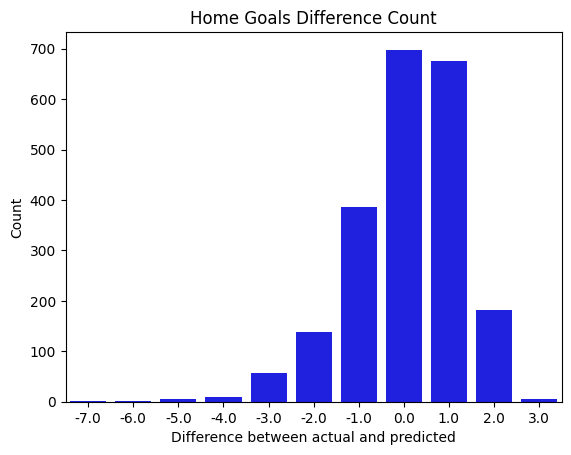

In [54]:
visualisations.histoplot(x_test, ha='Home')

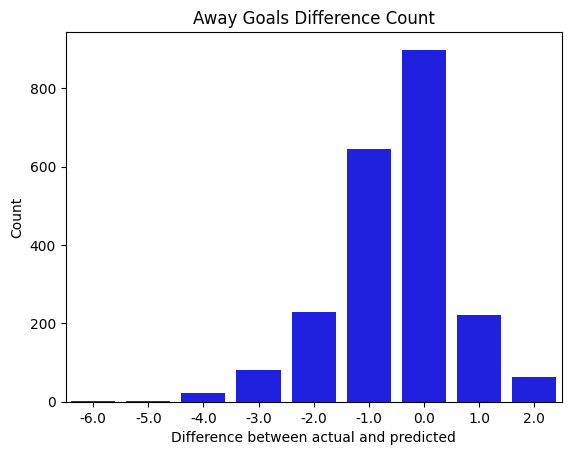

In [55]:
visualisations.histoplot(x_test, ha='Away')

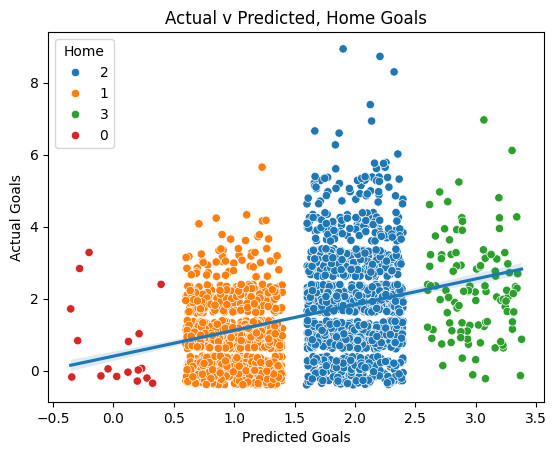

In [56]:
visualisations.actuals_predicted(x_test, ha='Home')

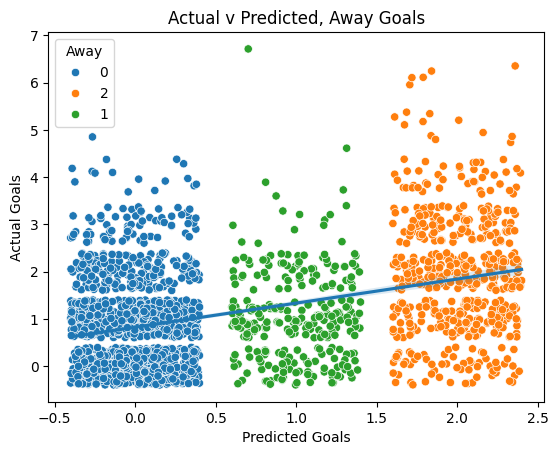

In [57]:
visualisations.actuals_predicted(x_test, ha='Away')

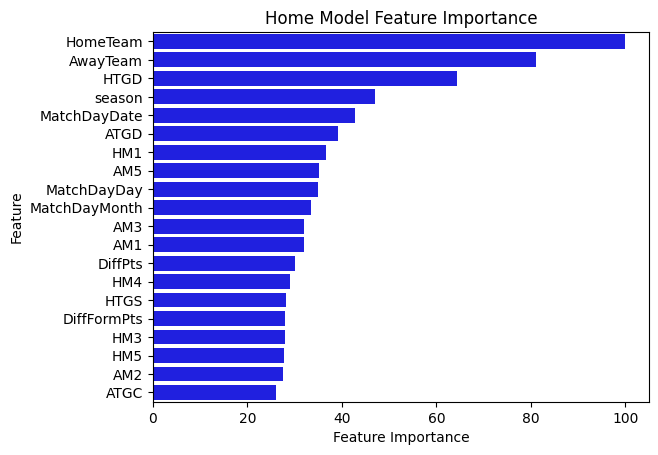

In [58]:
visualisations.plot_features(regressor_1, 'Home',n=20)

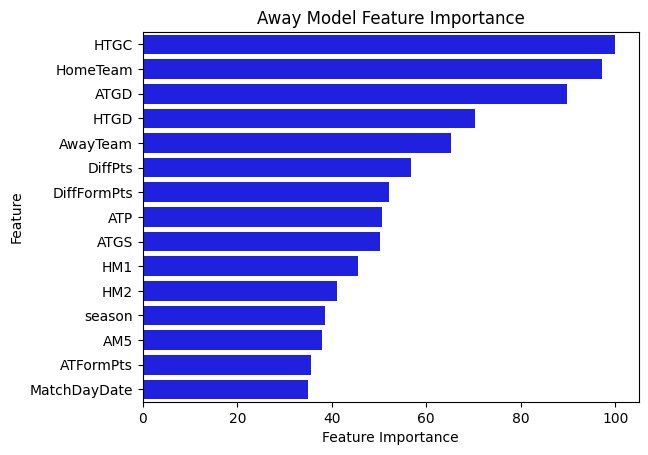

In [59]:
visualisations.plot_features(regressor_2, 'Away')